## 모델 체크

기존보다 성능이 떨어진 것 같아서...

In [1]:
import os

os.chdir('/opt/ml/P-Stage/1-STAGE/')

from PIL import Image

import wandb
import torch
import pandas as pd
import torch.nn as nn

import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
)

from config import get_args
from prepare import get_dataloader, get_classes
from metrics import (
    change_2d_to_1d,
    tensor_to_numpy,
    calulate_18class,
    tensor_images_to_numpy_images,
)

calculate_18class = calulate_18class

from log_helper import (
    log_f1_and_acc_scores,
    log_confusion_matrix,
    log_confusion_matrix_by_images,
)


def get_all_datas(args, model, dataloader, argmax=True):
    model.eval()

    all_images = torch.tensor([]).to(args.device)
    all_labels = torch.tensor([]).to(args.device)
    all_preds = torch.tensor([]).to(args.device)

    with torch.no_grad():
        for idx, (images, labels) in enumerate(dataloader):
            images, labels = images.to(args.device), labels.to(args.device)

            preds = model(images)

            if argmax:
                preds = torch.argmax(preds, dim=1)
                preds = change_2d_to_1d(preds)

            all_images = torch.cat((all_images, images))
            all_labels = torch.cat((all_labels, labels))
            all_preds = torch.cat((all_preds, preds))

    return all_images, all_labels, all_preds


def predict_and_logs_by_class_with_all_models(args, keys, models):
    """ return List[([mask_class], [gender_class], [age_class]]"""

    labels_by_models, preds_by_models = [], []

    summary_tables = pd.DataFrame([])
    cf_images = []

    for model, key in zip(models, keys):
        # keys: [mask, age, gender]

        args.train_key = key
        _, valid_dataloader = get_dataloader(args)

        images, labels, preds = get_all_datas(args, model, valid_dataloader)

        labels, preds = tensor_to_numpy(labels), tensor_to_numpy(preds)

        summary_table = log_f1_and_acc_scores(args, labels, preds)
        summary_tables = summary_tables.append(summary_table)

        fig1 = log_confusion_matrix(args, labels, preds)
        fig2 = log_confusion_matrix_by_images(args, model, images, labels, preds)

        cf_images.append(wandb.Image(fig1))
        cf_images.append(wandb.Image(fig2))

        wandb.log({f"{key} Confusion Matrix": cf_images})

        labels_by_models.append(labels)
        preds_by_models.append(preds)

        cf_images = []

    summary_tables.fillna(0, inplace=True)
    summary_tables = summary_tables.applymap(lambda x: "{:,.1f}%".format(x * 100))

    return summary_tables, labels_by_models, preds_by_models


def load_models(args):
    try:
        age_model = torch.load(args.age_model).to(args.device)
        gender_model = torch.load(args.gender_model).to(args.device)
        mask_model = torch.load(args.mask_model).to(args.device)

        age_model.eval()
        gender_model.eval()
        mask_model.eval()
    except Exception as e:
        raise e

    return [mask_model, gender_model, age_model]  # 순서 중요


def main(args):
    wandb.init(project="p-stage-1", reinit=True)
    wandb.config.update(args)
    wandb.run.name = f"predict-{wandb.run.name}"

    print(
        "".join([f"{k:<15} : {v}\n" for k, v in sorted(wandb.config.items(), key=len)])
    )

    models = load_models(args)
    keys = ["mask", "gender", "age"]

    # mga: mask, gender, age (sequence)

    (
        summary_tables,
        mga_label_lists,
        mga_output_lists,
    ) = predict_and_logs_by_class_with_all_models(args, keys, models)

    labels, preds = [], []

    for (mi, gi, ai) in zip(*mga_label_lists):
        labels.append(calculate_18class(mi, gi, ai))

    for (mi, gi, ai) in zip(*mga_output_lists):
        preds.append(calculate_18class(mi, gi, ai))

    ac_sco = accuracy_score(labels, preds)
    f1_sco = f1_score(labels, preds, average="macro")
    re_sco = recall_score(labels, preds, average="macro")
    pr_sco = precision_score(labels, preds, average="macro")

    table = wandb.Table(
        data=summary_tables.to_numpy(), rows=keys, columns=list(summary_tables)
    )

    wandb.log(
        {
            "predict_suumary_table(mask, gender, age)": table,
            "total_valid_accuracy": ac_sco,
            "total_valid_f1_score": f1_sco,
            "total_valid_pr_score": pr_sco,
            "total_valid_re_score": re_sco,
        }
    )

In [2]:
args = get_args()
args.device = "cuda:0" if torch.cuda.is_available() else "cpu"

args.valid_size=0.2
args.test=False
args.age_model = "age-04051654-dulcet-sweep-17.pt"
args.gender_model = "gender-04050240-pretty-sweep-4.pt"
args.mask_model = "mask-04051658-rich-sweep-17.pt"

args.model_path = "/opt/ml/best_weights"

args.age_model = os.path.join(args.model_path, args.age_model)
args.gender_model = os.path.join(args.model_path, args.gender_model)
args.mask_model = os.path.join(args.model_path, args.mask_model)

args

Namespace(age_model='/opt/ml/best_weights/age-04051654-dulcet-sweep-17.pt', aug_keys='CJ,FancyPCA', batch_size=64, data_dir='/opt/ml/input/data/train', device='cuda:0', epochs=25, gender_model='/opt/ml/best_weights/gender-04050240-pretty-sweep-4.pt', image_size=224, inf_filename='valid', loss_metric='f1_loss', lr=0.001, mask_model='/opt/ml/best_weights/mask-04051658-rich-sweep-17.pt', model_path='/opt/ml/best_weights', model_save=True, optimizer='adam', seed=42, test=False, train_key='mask', use_only_mask=False, valid_size=0.2, workers=2)

In [ ]:
models = load_models(args)
keys = ['mask', 'gender', 'age']

## Mask

In [17]:
mask_model, key = models[0], 'mask'

In [18]:
args.train_key = key

_, dataloader = get_dataloader(args)
_, labels, preds = get_all_datas(args, mask_model, dataloader)
labels, preds = tensor_to_numpy(labels), tensor_to_numpy(preds)

df = log_f1_and_acc_scores(args, labels, preds)

In [23]:
print(f"validation dataset's len: {len(dataloader.dataset)}")

validation dataset's len: 3780


In [19]:
df.head()

,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
mask,0.918486,1.0,0.849259,0.849259,0.859556,1.0,0.753704,0.753704,0.863158,1.0,0.759259,0.759259


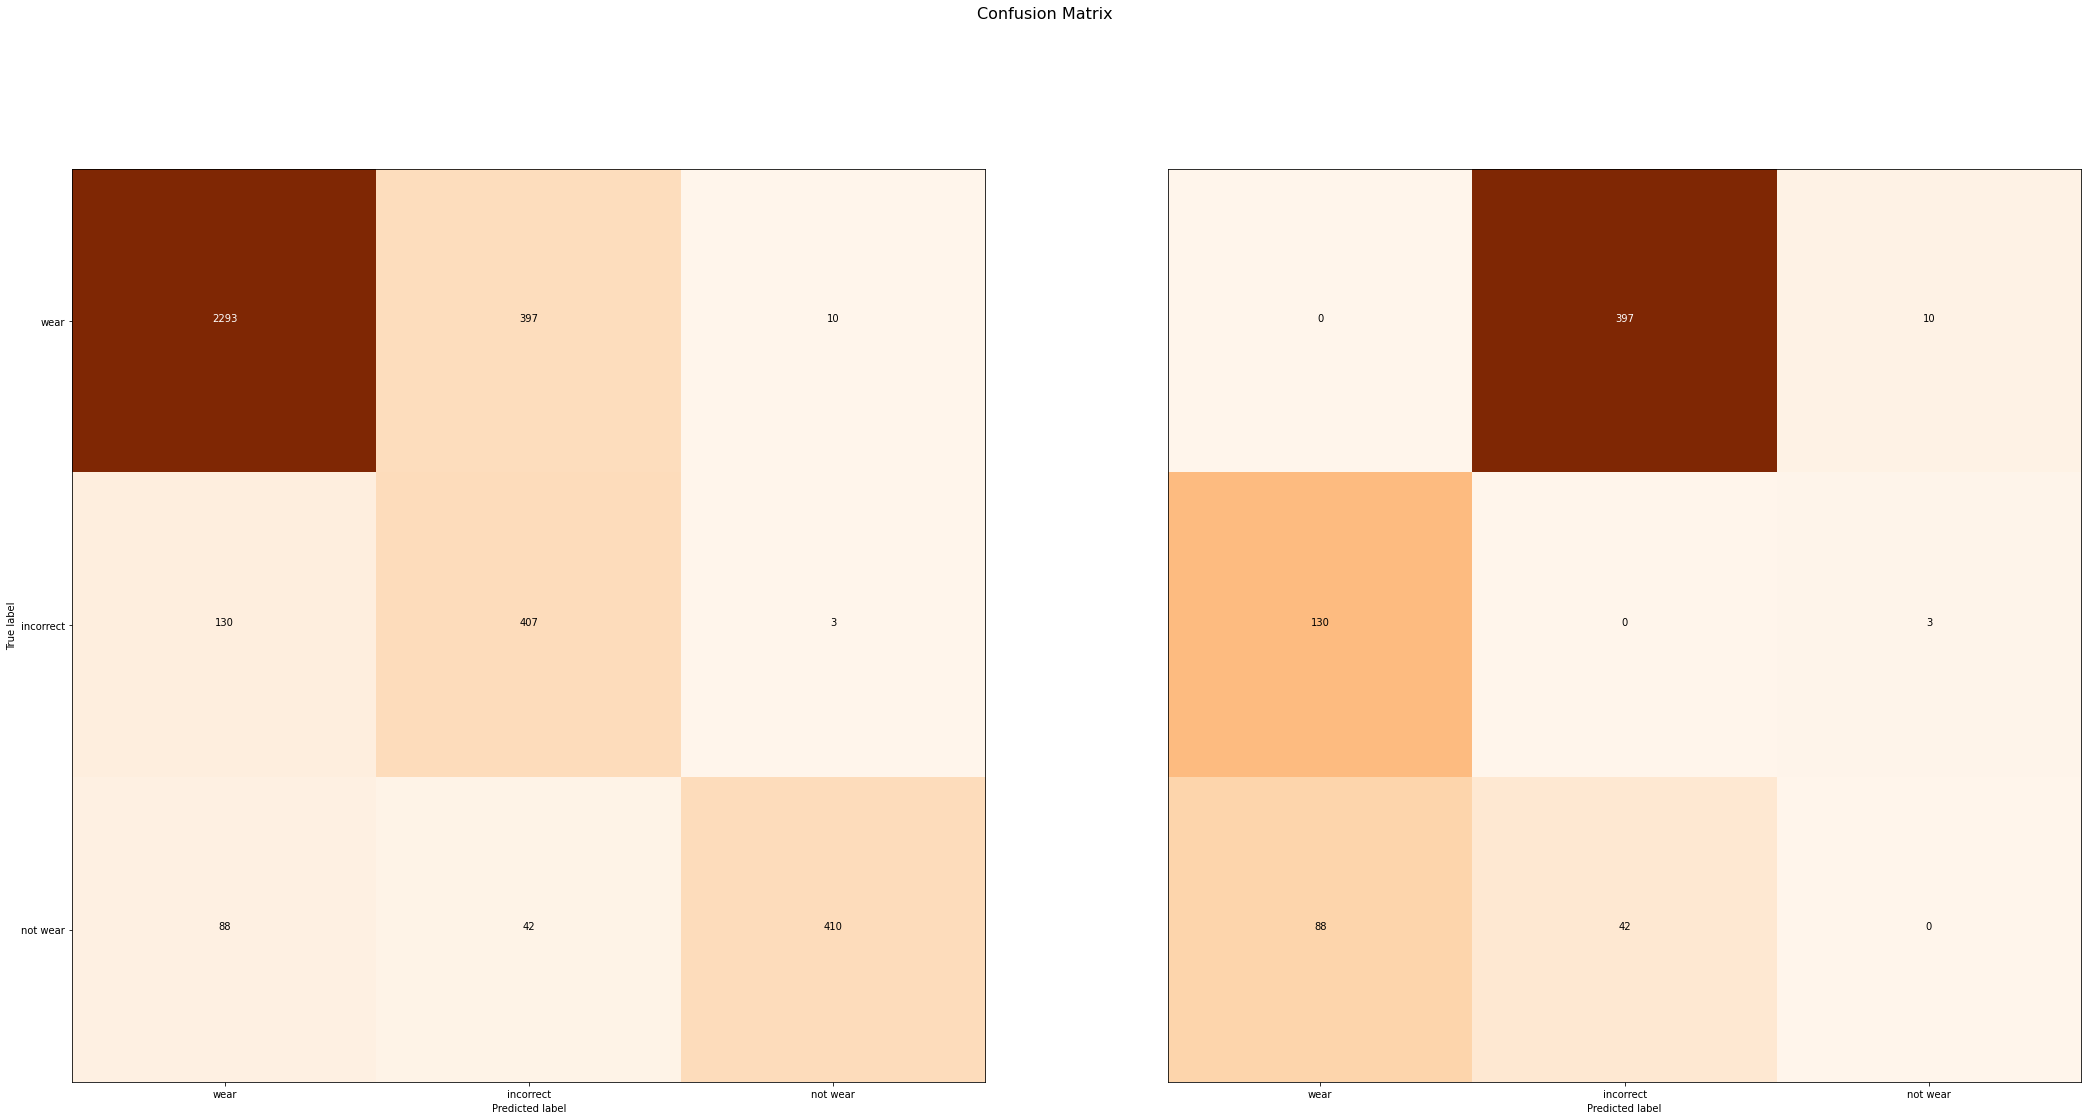

In [24]:
fig = log_confusion_matrix(args, labels, preds)

In [ ]:
gender_model, key = models[1], 'gender'

## Age

In [ ]:
age_model, key = models[2], 'age'

In [ ]:
if __name__ == "__main__":
    args = get_args()
    args.device = "cuda:0" if torch.cuda.is_available() else "cpu"

    print("PyTorch version:[%s]." % (torch.__version__))
    print("This code use [%s]." % (args.device))

    main(args)
